## Uno Cards Number Detection


In [8]:
import glob
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np
import random

### 1. Load dataset

Load the images found in `DATASET/*`. Also analyze the filename to extract the label for each image.

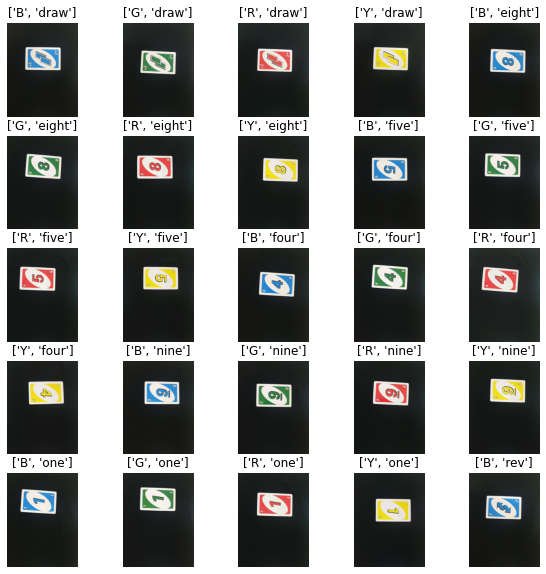

In [9]:
# Load dataset
images = []
labels = []

for fn in glob.glob("DATASET/*"):
  # Load image
  img = cv.imread(fn)
  images.append(img)

  # Parse image filename for label
  bname = os.path.basename(fn) # only get filename ( remove directory path )
  rname, _ = os.path.splitext(bname) # remove extension

 
  # The second part is the color (R,G,B,Y)
  # rest is number (or special)
  name_parts = rname.split("_")
  color = name_parts[1]
  label = "_".join([name_parts[0]]+name_parts[2:])

  # Now color is R,G,B,Y
  # label is ZERO, TWO_DRAW, SKIP, ...
  labels.append([color, label])

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  # Last indices is the reverse BGR to RGB
  # Opencv works in BGR, matplotlib need to display in RGB
  plt.imshow(images[i][:,:,::-1])
  plt.axis('off')
  plt.title(str(labels[i]))

### 2. Crop out card

An edge detection is performed to find the cards in the image. This is done with an adaptive threshold with is the best method to have a fast and lighting robust edge detection. Then any external contour is picked as potential card contour. The inner contour is picked as the card contour. This contour must also have a minimal area so that noise is not picked up. The contour is approximated with an oriented bounding box (OBB). The four corner points are then used to perform a perspective transform, to reorient and crop the card image.

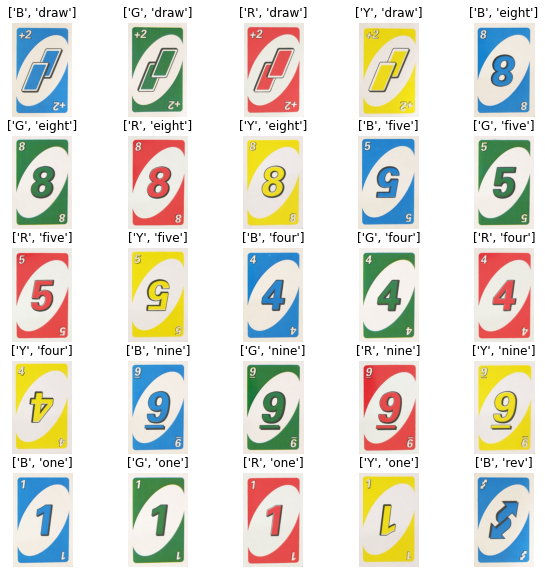

In [10]:
# Find region of interest (ROI) for each image
for i in range(len(images)):
  # Do adaptive threshold to find edges
  # Apply a gaussian blur just before to 
  # make sure it doesn't pick up noisy edges
  gray = cv.cvtColor(images[i], cv.COLOR_BGR2GRAY)
  gray = cv.GaussianBlur(gray, (21, 21), 0)
  th = cv.adaptiveThreshold(gray, 255,
      cv.ADAPTIVE_THRESH_GAUSSIAN_C,
      cv.THRESH_BINARY, 11, 2)

  # Get negative to find contours
  th = 255 - th 

  # We can notice there is a large area around
  # the uno card. We will use to our advantage.
  # In th, currently the image is a the edges
  # detected in the image. We apply some dilatation
  # to close any contour AND when cropping, make
  # sure that we don't get anything outside the card

  # When finding the contours, we get two contours
  # around the card. We pick the most inner one.
  # The dilatation process will make sure the inner
  # contour is exclusively inside the card
  #

  kernel = np.ones((3, 3), np.uint8)
  th = cv.morphologyEx(th, cv.MORPH_DILATE, kernel, iterations=10)

  # Find biggest external contour which is 
  # quadrilatel like
  contours, hierarchy = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  idx_biggest = np.argmax([cv.contourArea(c) for c in contours])
  idx_inner = hierarchy[0][idx_biggest][2]
  cnt = contours[idx_inner]

  # cv.drawContours(images[i], contours, -1, (0, 0, 255), 2)
  # cv.drawContours(images[i], contours, idx_inner, (0, 0, 255), 2)

  # Find oriented bounding box around card
  rect = cv.minAreaRect(cnt)
  box = cv.boxPoints(rect)

  # Have the most top-left first, and also 
  # the contour should be clockwise from the 
  # previous functions
  idx_leftop = np.argmin([p[0]+p[1] for p in box])
  box_ordered = []
  for j in range(4):
    box_ordered.append(box[(idx_leftop+j)%4])
  box = np.array(box_ordered)


  box_l11 = np.linalg.norm(box[0]-box[1])
  box_l12 = np.linalg.norm(box[2]-box[3])

  box_l21 = np.linalg.norm(box[1]-box[2])
  box_l22 = np.linalg.norm(box[3]-box[0])

  box_l1 = (box_l11+box_l12)/2
  box_l2 = (box_l21+box_l22)/2

  # Card is straight
  new_width, new_height = None, None
  if box_l1 < box_l2:
    new_points = np.array([
      [0, 0], [box_l1, 0], [box_l1, box_l2], [0, box_l2]])
    new_width = box_l1
    new_height = box_l2

  # Card is on its side
  else:
    new_points = np.array([[box_l2, 0], [box_l2, box_l1], [0, box_l1], [0, 0]])
    new_width = box_l2
    new_height = box_l1

  # Compute perspective transform matrix and get wrapped
  # image which is only the card
  M = cv.getPerspectiveTransform(np.float32(box), np.float32(new_points))
  roi = cv.warpPerspective(images[i], M, (round(new_width), round(new_height)))

  images[i] = roi

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(images[i][:,:,::-1])
  plt.axis('off')
  plt.title(str(labels[i]))

### 3. Normalize image sizes

In [11]:
CARD_WIDTH = 400
CARD_RATIO = 1.5
CARD_HEIGHT = round(CARD_WIDTH*CARD_RATIO)

for i in range(len(images)):
  images[i] = cv.resize(images[i], (CARD_WIDTH, CARD_HEIGHT), interpolation=cv.INTER_AREA)

### 4. Split the dataset into training and testing

80 % of the dataset is used for training and 20% is used for testing. 

In [12]:
# Do testing for color
# Take a 80% train and 20% test proporition
indices = list(range(len(images)))
random.shuffle(indices)

train_indices = indices[:int(len(images)*0.8)]
test_indices = indices[int(len(images)*0.8):]

print("TRAIN: ", train_indices)
print("TEST: ", test_indices)

TRAIN:  [21, 5, 7, 20, 35, 50, 15, 30, 28, 19, 36, 4, 16, 47, 43, 0, 26, 17, 14, 13, 37, 41, 49, 29, 40, 38, 34, 31, 3, 48, 2, 10, 1, 51, 27, 22, 8, 44, 18, 45, 6]
TEST:  [23, 11, 24, 39, 9, 46, 32, 25, 33, 12, 42]


### 5. Number detection on training data
 
   * Do an edge detection on the image
   * Do a contour detection (external), for each contour, fill it, this creates the "silhouette image"
   * Crop the center of the image of the silhouette image, this is the region of interest (ROI)
   * The ROI is split into a grid, where for each cell, count the number of 255, this make a feature vector

#### 5.1 Do edge detection

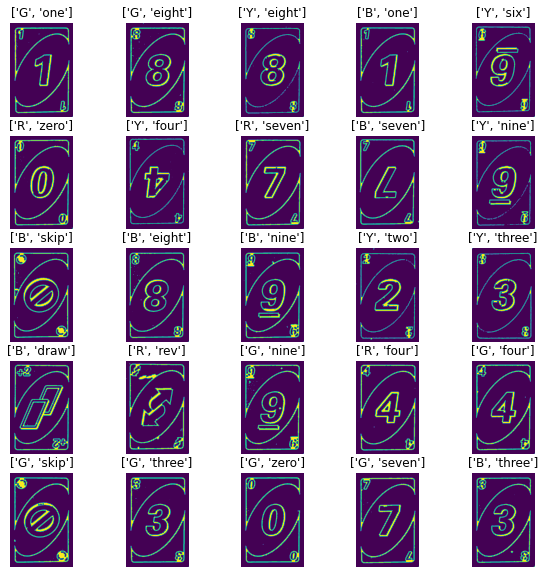

In [14]:
train_th = []

for i in train_indices:
  # Convert image to grayscale
  gray = cv.cvtColor(images[i], cv.COLOR_BGR2GRAY)
  gray = cv.GaussianBlur(gray, (7, 7), 0)

  # Do an edge detection
  th = cv.adaptiveThreshold(gray, 255,
      cv.ADAPTIVE_THRESH_GAUSSIAN_C,
      cv.THRESH_BINARY, 11, 2)

  # Get negative to find contours
  th = 255 - th 
  
  # Close any contour
  kernel = np.ones((7, 7), np.uint8)
  th = cv.morphologyEx(th, cv.MORPH_CLOSE, kernel)
  train_th.append(th)
    
# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(train_th[i])
  plt.axis('off')
  plt.title(str(labels[train_indices[i]]))

#### 5.2 Create silhouette image

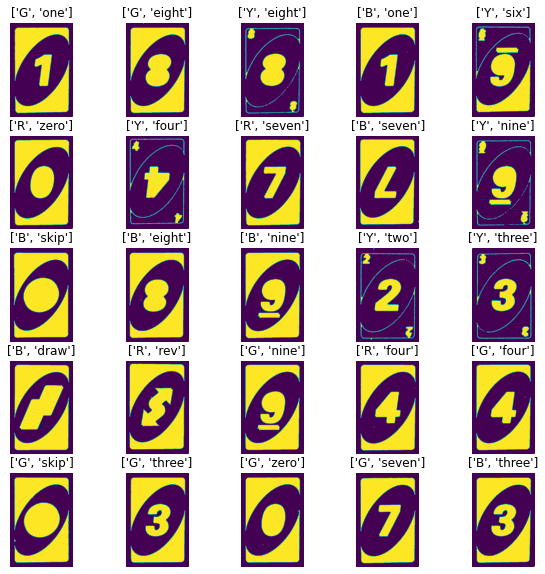

In [17]:
train_silhouettes = []

for ii, i in enumerate(train_indices):
  # Create silhouette image
  # Each external contour is found in the image
  # and filled to create the silhouette image.
  contours, _ = cv.findContours(train_th[ii], cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

  silhouette = np.zeros_like(train_th[ii])
  cv.drawContours(silhouette, contours, -1, 255, -1)
    
  train_silhouettes.append(silhouette)

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(train_silhouettes[i])
  plt.axis('off')
  plt.title(str(labels[train_indices[i]]))

#### 5.3 Crop template

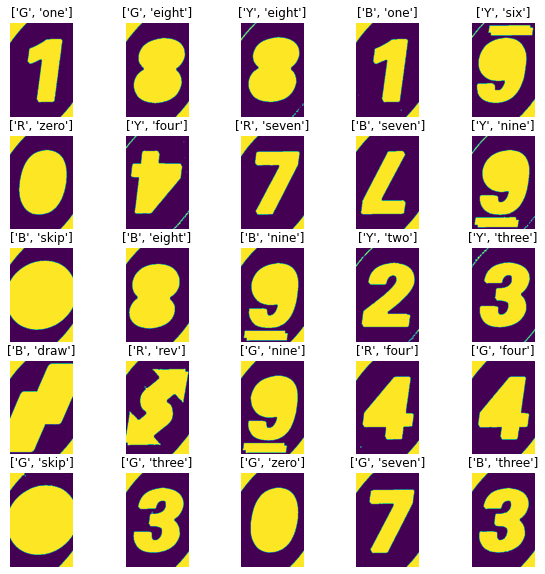

In [20]:
CENTER_ROI_WIDTH = 200
CENTER_ROI_HEIGHT = 300

train_roi = []

for ii, i in enumerate(train_indices):
  center = (train_silhouettes[ii].shape[1]//2, train_silhouettes[ii].shape[0]//2)
  roi = train_silhouettes[ii][center[1]-CENTER_ROI_HEIGHT//2:center[1]+CENTER_ROI_HEIGHT//2, 
      center[0]-CENTER_ROI_WIDTH//2:center[0]+CENTER_ROI_WIDTH//2]
  train_roi.append(roi)

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(train_templates[i])
  plt.axis('off')
  plt.title(str(labels[train_indices[i]]))

#### 5.4 Compute local histogram

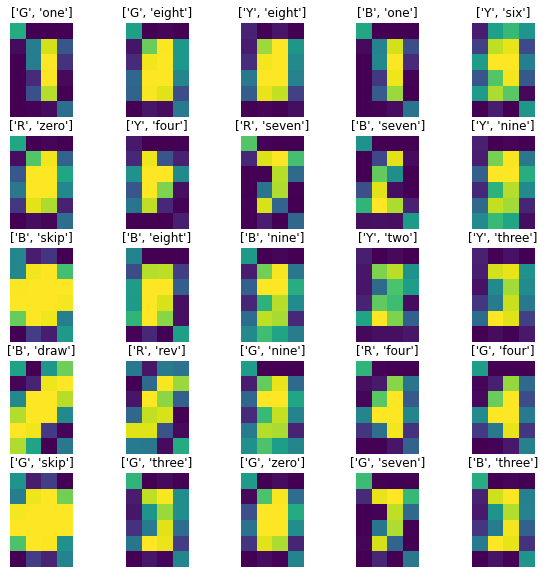

In [23]:
COUNT_GRID_X = 4
COUNT_GRID_Y = 6
number_comps = []

for ii, i in enumerate(train_indices):
  comp = []
  roi = train_roi[ii]
  for ri in range(COUNT_GRID_Y):
    for rj in range(COUNT_GRID_X):
      local_roi = roi[int(ri*(CENTER_ROI_HEIGHT/COUNT_GRID_Y)):int((ri+1)*(CENTER_ROI_HEIGHT/COUNT_GRID_Y)),
        int(rj*(CENTER_ROI_WIDTH/COUNT_GRID_X)):int((rj+1)*(CENTER_ROI_WIDTH/COUNT_GRID_X))]
      comp.append(cv.countNonZero(local_roi))

  comp = np.array(comp)
  number_comps.append(comp)

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(number_comps[i].reshape(COUNT_GRID_Y, COUNT_GRID_X))
  plt.axis('off')
  plt.title(str(labels[train_indices[i]]))

### 6. Test against testing data

   * Create the silhouette image for the test data similar to the training data.
   * For each template in training data, do a template matching on the test silhouette image - Do two matching, one normal      and one with the feature vector rotated by 180° degrees.
   * Pick the best matching template between both.
   * Make sure that train and test label for color match


In [24]:
good, bad = 0, 0
for i in test_indices:
  # Convert image to grayscale
  gray = cv.cvtColor(images[i], cv.COLOR_BGR2GRAY)
  gray = cv.GaussianBlur(gray, (7, 7), 0)

  # Do an edge detection
  th = cv.adaptiveThreshold(gray, 255,
      cv.ADAPTIVE_THRESH_GAUSSIAN_C,
      cv.THRESH_BINARY, 11, 2)

  # Get negative to find contours
  th = 255 - th 

  kernel = np.ones((7, 7), np.uint8)
  th = cv.morphologyEx(th, cv.MORPH_CLOSE, kernel)

  # Create silhouette image
  # Each external contour is found in the image
  # and filled to create the silhouette image.
  contours, _ = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

  silhouette = np.zeros_like(th)
  cv.drawContours(silhouette, contours, -1, 255, -1)


  # Crop the template in the center
  center = (silhouette.shape[1]//2, silhouette.shape[0]//2)
  roi = silhouette[center[1]-CENTER_ROI_HEIGHT//2:center[1]+CENTER_ROI_HEIGHT//2, 
      center[0]-CENTER_ROI_WIDTH//2:center[0]+CENTER_ROI_WIDTH//2]


    
  comp = []
  for ri in range(COUNT_GRID_Y):
    for rj in range(COUNT_GRID_X):
      local_roi = roi[int(ri*(CENTER_ROI_HEIGHT/COUNT_GRID_Y)):int((ri+1)*(CENTER_ROI_HEIGHT/COUNT_GRID_Y)),
        int(rj*(CENTER_ROI_WIDTH/COUNT_GRID_X)):int((rj+1)*(CENTER_ROI_WIDTH/COUNT_GRID_X))]
      comp.append(cv.countNonZero(local_roi))

  comp = np.array(comp)


  closest_coeff = None
  closest_idx = None

  dist_comp = [np.linalg.norm(c - comp) for c in number_comps]
  dist_comp_flip = [np.linalg.norm(c[::-1] - comp) for c in number_comps]

  closest_idx = np.argmin(dist_comp)
  closest_idx_flip = np.argmin(dist_comp_flip)

  if dist_comp[closest_idx] < dist_comp_flip[closest_idx_flip]:
    closest_idx = train_indices[closest_idx]
  else:
    closest_idx = train_indices[closest_idx_flip]


  if labels[closest_idx][1] == labels[i][1]:
    good += 1
  else:
    bad += 1
    print(labels[closest_idx][1], labels[i][1])

print(f"Number testing : GOOD {good}/BAD {bad}/TOTAL {good+bad}")

Number testing : GOOD 11/BAD 0/TOTAL 11
